# Self-Driving Car Engineer Nanodegree


## Vehicle Detection** 


## Import Packages

In [1]:
#importing some useful packages
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib
%matplotlib inline

/home/emmanuel/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Read  Images

Size of car data set is:     8792
Size of non car data set is: 8968
Shape of images is:         (64, 64, 3)


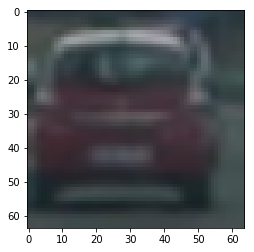

In [2]:
# Load car and non-car image sets
carImgs = glob.glob('vehicles/vehicles/*/*.png')
noncarImgs = glob.glob('non-vehicles/non-vehicles/*/*.png')
testImg = cv2.imread(carImgs[1],cv2.IMREAD_COLOR)
rgbImage =  cv2.cvtColor(testImg,cv2.COLOR_BGR2RGB)

print("Size of car data set is:    ", len(carImgs))
print("Size of non car data set is:", len(noncarImgs))
print("Shape of images is:        ", rgbImage.shape)
plt.imshow(rgbImage ) 

## FUNCTIONS

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file,cv2.IMREAD_COLOR)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),hist_bins=32, orient=9, pix_per_cell=8, 
                        cell_per_block=2, hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    else: feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)     
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

## Function Testing

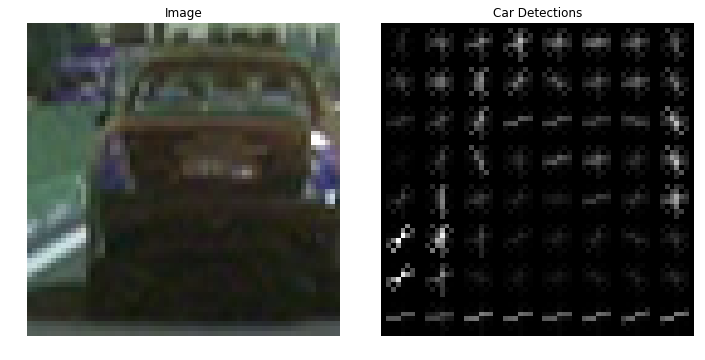

In [4]:
# HOG Testing
orient = 9
pix_per_cell = 8
cell_per_block = 2

image = cv2.imread(carImgs[0])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Call our function with vis=True to see an image output
features, hog_image =  get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)


f, (ax1,ax2) = plt.subplots(1,2, figsize=(10,6))
f.tight_layout()
ax1.axis('off')
ax1.set_title('Image')
ax1.imshow(image)
        
ax2.axis('off')
ax2.set_title('Car Detections')
ax2.imshow(hog_image, cmap='gray')
        


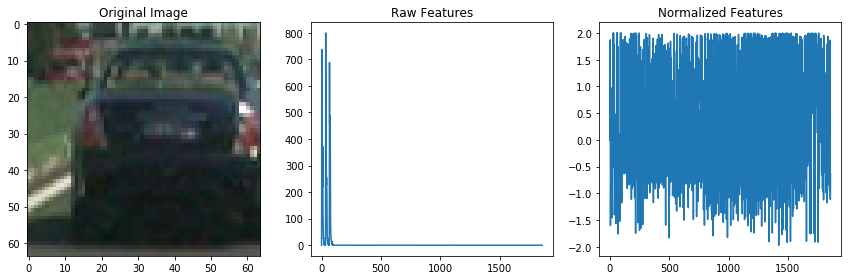

In [5]:
#Testing HOG, Color Histogram and Normalization    
car_feature = extract_features(carImgs[0:5], color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32,orient=9,pix_per_cell=8,cell_per_block=2,hog_channel=0,
                        spatial_feat=False, hist_feat=True, hog_feat=True)                        

if len(car_feature) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_feature)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(carImgs[0:5]))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(carImgs[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

In [6]:
import os
os.listdir("test_images/")

['test5.jpg',
 'test1.jpg',
 'test3.jpg',
 'test2.jpg',
 'test7.jpg',
 'test6.jpg',
 'test4.jpg',
 '.DS_Store']

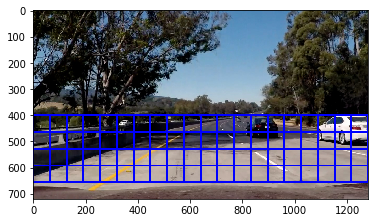

In [7]:
#Testing Slide Window
testImg = cv2.imread("test_images/test5.jpg",cv2.IMREAD_COLOR)
rgbImage =  cv2.cvtColor(testImg,cv2.COLOR_BGR2RGB)

windows = slide_window(rgbImage, x_start_stop=[None, None], y_start_stop=[400, 680], 
                    xy_window=(128,128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(rgbImage, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

## Feature Extraction

In [8]:
### Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 48    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


In [9]:
car_features = extract_features(carImgs, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
noncar_features = extract_features(noncarImgs, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, noncar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))




MemoryError: 

## SVM

In [ ]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

In [ ]:
# Save best clf and scaler
joblib.dump(svc, 'clf.pkl')
joblib.dump(X_scaler, 'scaler.pkl')

## Vehicle Detection

In [10]:
# Load MLP and Scaler
svc = joblib.load('clf.pkl')
X_scaler = joblib.load('scaler.pkl')

In [11]:
window_sizes = range(96,128,32)
def search_windows(image, vis = True):
    on_windows = []
    
    # implement Multi-scale Windows; increase window size 16px from 320px to 720px
    for size in window_sizes:
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 680], 
                            xy_window=(size, size), xy_overlap=(0.75, 0.75))  
        
        for window in windows:
            # Extract the test window from original image
            test_img = cv2.resize((image[window[0][1]: window[1][1], window[0][0]: window[1][0]]),(64,64))
            
                      
            features = single_img_features(test_img, color_space=color_space, spatial_size=spatial_size,hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,  
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
            
            test_features = X_scaler.transform(np.array(features).reshape(1, -1))

            prediction = svc.predict(test_features)
           
            
            #If positive (prediction == 1) then save the window
            if prediction == 1:
                on_windows.append(window)
               
    
    result = np.copy(image)
    mask = np.zeros_like(image)
    # Draw all of the boxes on a mask image
    mask = draw_boxes(mask, bboxes=on_windows, thick=-1)
    # Find the contours in the mask
    im2, contours, hierarchy = cv2.findContours(mask[:,:,2].astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        # Get the coordinates of a bounding rect for each contour
        x,y,w,h = cv2.boundingRect(cnt)
        # Draw the bounding rectangles on the result image
        cv2.rectangle(result, (x, y), (x + w, y + h), (0,255,0), 6)
        
    
    if vis: 
        
        f, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(10,6))
        f.tight_layout()
        ax1.axis('off')
        ax1.set_title('Image')
        ax1.imshow(image)
        ax2.axis('off')
        ax2.set_title('Car Detections')
        ax2.imshow(mask, cmap='hot')
        ax3.axis('off')
        ax3.set_title('Annotated Image')
        ax3.imshow(result)

    
    return result

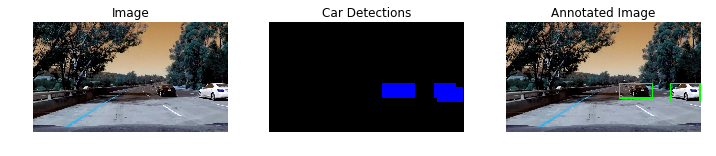

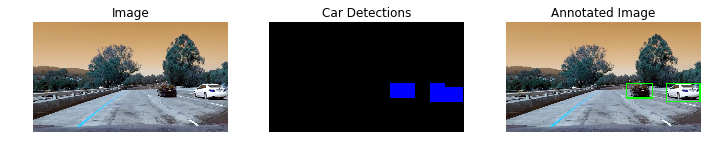

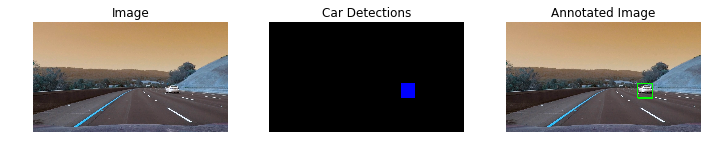

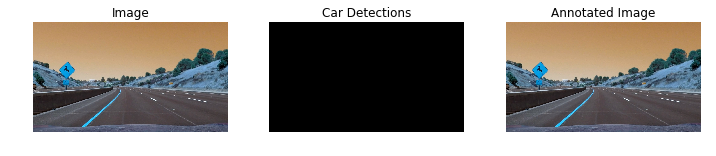

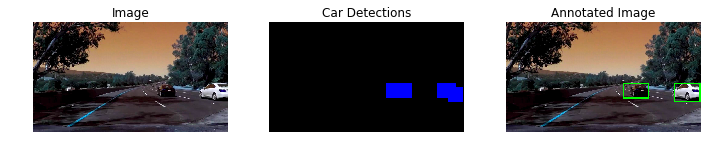

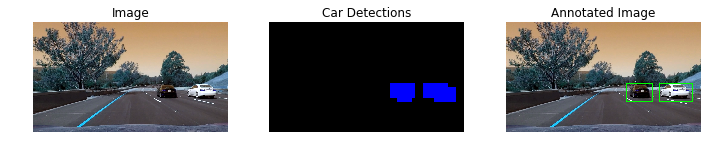

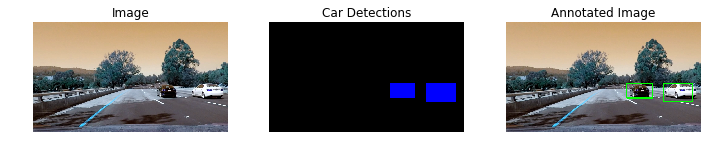

In [12]:
for image in glob.glob('test_images/*.jpg'):
    testImg = cv2.imread(image,cv2.IMREAD_COLOR)
    search_windows(testImg)  


## Test on Videos

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [21]:
from collections import deque

n_frames = 30
history = deque(maxlen=n_frames) # where n_frames is number of history frames you want to store

window_sizes = range(64,128,32)
window_sizes = range(96,128,32)

def video_pipeline(img):
    image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    on_windows = []
    # implement Multi-scale Windows; increase window size 16px from 320px to 720px
    for size in window_sizes:
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 680], 
                            xy_window=(size, size), xy_overlap=(0.75, 0.75))  
        
        for window in windows:
            # Extract the test window from original image
            test_img = cv2.resize((image[window[0][1]: window[1][1], window[0][0]: window[1][0]]),(64,64))
            
                      
            features = single_img_features(test_img, color_space=color_space, spatial_size=spatial_size,hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,  
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
            
            test_features = X_scaler.transform(np.array(features).reshape(1, -1))

            prediction = svc.predict(test_features)
           
            
            #If positive (prediction == 1) then save the window
            if prediction == 1:
                on_windows.append(window)            
    
  
    result = np.copy(img)
    mask = np.zeros_like(image)
    # Draw all of the boxes on a mask image
    mask = draw_boxes(mask, bboxes=on_windows, thick=-1)
    # Find the contours in the mask
    im2, contours, hierarchy = cv2.findContours(mask[:,:,2].astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

        
    for cnt in contours:
        # Get the coordinates of a bounding rect for each contour
        x,y,w,h = cv2.boundingRect(cnt)
        # save coords to history
        history.append([x,y,x+w,y+h])
    
    # get recent boxes
    recent_boxes = np.array(history).tolist()
    
    # groups the object candidate rectangles
    rects,w = cv2.groupRectangles(recent_boxes, 7,.1)
    
    # draw rectangles
    for rect in rects:
        cv2.rectangle(result, (rect[0], rect[1]), (rect[2],rect[3]), (0,255,0), 5)
   
    return result

### Testing in video

In [22]:
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(video_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile('result.mp4', audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [51:37<00:02,  2.42s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 51min 33s, sys: 17.2 s, total: 51min 50s
Wall time: 51min 38s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))